# Import libraries
This notebook is built based on https://github.com/mginolin/standax/tree/main/notebooks from Madeleine Ginolin

In [ ]:
import numpy as np
import pandas as pd
from standax import standardisation
from astropy.cosmology import Planck18
from getdist import plots, MCSamples
from scipy import stats
from tqdm.autonotebook import tqdm as notebook_tqdm

# Import sample

In [2]:
df = pd.read_parquet("../data/inference_data_frame.parquet")
new_cols = ["cov_mag_c", "cov_mag_x1", "cov_x1_c"]
df[new_cols] = 0.0
df = df.rename(columns={"magobs": "mag"})
df = df.rename(columns={"magobs_err": "mag_err"})
df = df.rename(columns={"prompt": "h_low"})
df = df.rename(columns={"localcolor": "localrestframe_gz"})
df = df.rename(columns={"localcolor_err": "localrestframe_gz_err"})

df["h_low"] = stats.norm.cdf(1, loc=df["localrestframe_gz"], scale=df["localrestframe_gz_err"])
df["h_low_err"] = 1e-4

In [3]:
print(df.head())

         mag   mag_err        x1    x1_err         c     c_err         h_low  \
0  18.423609  0.037402 -0.678802  0.124578 -0.059034  0.026310  2.577132e-45   
1  19.866919  0.031878  0.340098  0.244602 -0.034739  0.034989  9.952110e-01   
2  19.281153  0.034327  0.349803  0.280703  0.016699  0.030237  1.000000e+00   
3  17.979933  0.035642  0.438707  0.152932 -0.093161  0.033097  9.925816e-01   
4  17.955853  0.032250 -0.293674  0.358225 -0.001917  0.036892  1.000000e+00   

   localrestframe_gz  localrestframe_gz_err        z  cov_mag_c  cov_mag_x1  \
0           1.254714               0.018092  0.07295        0.0         0.0   
1           0.883331               0.045034  0.14385        0.0         0.0   
2           0.718549               0.021206  0.12855        0.0         0.0   
3           0.955976               0.018070  0.06685        0.0         0.0   
4           0.779988               0.034926  0.08055        0.0         0.0   

   cov_x1_c  h_low_err  
0       0.0     0.0

In [4]:
data_to_fit = df[["mag", "mag_err", "x1", "x1_err", "c", "c_err", "h_low", "h_low_err",
                    "cov_mag_c", "cov_mag_x1", "cov_x1_c"]].dropna()

residuals = df['mag'] - Planck18.distmod(df['z']).value + 19.3
data_to_fit['mag'] = residuals

In [5]:
print(data_to_fit.head())

        mag   mag_err        x1    x1_err         c     c_err         h_low  \
0  0.060927  0.037402 -0.678802  0.124578 -0.059034  0.026310  2.577132e-45   
1 -0.070998  0.031878  0.340098  0.244602 -0.034739  0.034989  9.952110e-01   
2 -0.391670  0.034327  0.349803  0.280703  0.016699  0.030237  1.000000e+00   
3 -0.183968  0.035642  0.438707  0.152932 -0.093161  0.033097  9.925816e-01   
4 -0.633332  0.032250 -0.293674  0.358225 -0.001917  0.036892  1.000000e+00   

   h_low_err  cov_mag_c  cov_mag_x1  cov_x1_c  
0     0.0001        0.0         0.0       0.0  
1     0.0001        0.0         0.0       0.0  
2     0.0001        0.0         0.0       0.0  
3     0.0001        0.0         0.0       0.0  
4     0.0001        0.0         0.0       0.0  


# Fit sample with total chi2

In [6]:
(best_params_l, sigmaint_l, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit,
                                                      init=[-0.2, 3.2], 
                                                      xkeys=["x1", "c"], 
                                                      sigmaint_guess=0.15, 
                                                      model="linear", 
                                                      nfetch=3, verbose=True,
                                                     lmbda=1e4, fit_method="tncg")

fitting using <function fit_tncg at 0x12eb91760> using guess: {'offset': Array(0., dtype=float32), 'x_model': Array([[-0.6788016 ,  0.34009764,  0.34980252, ...,  0.14060864,
        -0.03630905,  0.5524926 ],
       [-0.0590344 , -0.03473862,  0.01669939, ...,  0.13394846,
        -0.05345613, -0.02007347]], dtype=float32), 'coefs': Array([-0.2,  3.2], dtype=float32)}
 -> fitting options {'lmbda': 10000.0, 'sigmaint': 0.15}
reaching sigmaint: 0.1536300927400589
leading to parameters: {'coefs': Array([-0.16287112,  3.0602608 ], dtype=float32), 'offset': Array(-0.08420349, dtype=float32), 'x_model': Array([[-0.69589186,  0.29486847,  0.45891175, ...,  0.18443069,
        -0.03511915,  0.3252641 ],
       [-0.04473964, -0.01734332, -0.0071177 , ...,  0.10997874,
        -0.05677083,  0.01690203]], dtype=float32)}
reaching sigmaint: 0.1536255031824112
leading to parameters: {'coefs': Array([-0.16287112,  3.0602608 ], dtype=float32), 'offset': Array(-0.08420349, dtype=float32), 'x_model': 

/Users/atrigui/miniconda3/envs/standax_no_metal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
alpha = best_params_l['coefs'][0]
chain_alpha = mcmc_l.get_samples()['coefs'][:,0]
alpha_err = np.sqrt(np.sum((chain_alpha-alpha)**2)/len(chain_alpha))
beta = best_params_l['coefs'][1]
chain_beta = mcmc_l.get_samples()['coefs'][:,1]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
# step = best_params_l['coefs'][2]
# chain_step = mcmc_l.get_samples()['coefs'][:,2]
# step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = best_params_l['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))

In [8]:
print(alpha, alpha_err)
print(beta, beta_err)

-0.16287112 0.00394845
3.0602608 0.0279617


Removed no burn in


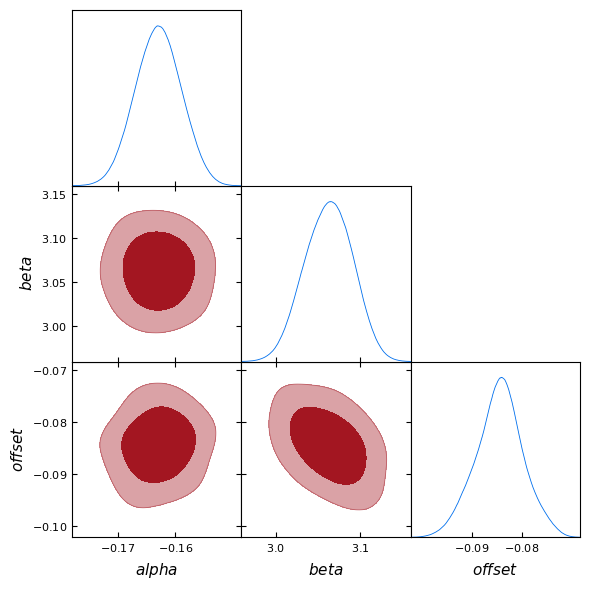

In [9]:
samples = np.vstack([chain_alpha, chain_beta, chain_offset]).T
names = ["alpha", "beta", "offset"]
labels = ["alpha", "beta", "offset"]

gds = MCSamples(samples=samples, names=names, labels=labels)

g = plots.getSubplotPlotter()
g.triangle_plot([gds],
                filled=True,
                contour_levels=[0.68, 0.95],
                colors=["#A31621"])